In [1]:
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, zscore, pearsonr, wilcoxon
import pybedtools as pbt
from scipy.integrate import simps
from IPython.display import clear_output

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.7)
    return True

In [2]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

### Okay, first thing to do here is to get information on TSS arranged by strand and chromosomes

In [3]:
gene_tss_info = {'positive': {}, 'negative': {}}
for chrom in chroms:
    gene_tss_info['positive'][chrom] = []
    gene_tss_info['negative'][chrom] = []
    with open('./data/annotation/chrom_wise_gencode_tss/%s.bed' % chrom) as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            up = int(c[1]) - 1000
            down = int(c[1]) + 1000 + 1
            if c[5] == '+':
                gene_tss_info['positive'][chrom].append((up, down, c[3]))
            else:
                gene_tss_info['negative'][chrom].append((up, down, c[3]))

In [4]:
utr5_info = {'positive': {}, 'negative': {}}
for chrom in chroms:
    utr5_info['positive'][chrom] = []
    utr5_info['negative'][chrom] = []
    with open('./data/annotation/chrom_wise_genocode_utr_5/%s.bed' % chrom) as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            up = int(c[1]) - 1000
            down = int(c[1]) + 1000 + 1
            if c[5] == '+':
                utr5_info['positive'][chrom].append((up, down, c[3]))
            else:
                utr5_info['negative'][chrom].append((up, down, c[3]))

### Lets load the expectation array in each of the promoter region and save it to a numpy. This is a 2D array array of shape (no. of promoters, +/- regions around TSS)

In [66]:
def load_scores(chrom, chrom_info, strand):
    scores_dir = './data/quad_graph_single_base_scores/%s/%s/*_exp_score.npy' % (
            chrom, strand)
    chrom_score = np.zeros(chrom_info[chrom])
    for fn in tqdm(glob.glob(scores_dir), desc="%s %s" % (chrom, strand)):
            exp = np.load(fn)
            if exp.shape[0] > 1:
                e_indices = np.array(exp[:, 0], dtype=int)
                e_scores = np.array(exp[:, 1], dtype=float)
                chrom_score[e_indices] += e_scores
    return chrom_score

gene_sense_exp = []
gene_antisense_exp = []
for strand, opp_strand in zip(['positive', 'negative'], ['negative', 'positive']):
    for chrom in chroms:
        exp_scores = load_scores(chrom, chrom_info, strand)
        for i in gene_tss_info[strand][chrom]:
            if strand == 'positive':
                gene_sense_exp.append(
                    [2**(-1/x) if x !=0 else 0 for x in exp_scores[i[0]:i[1]]]
                )
            else:
                gene_sense_exp.append(
                    [2**(-1/x) if x !=0 else 0 for x in exp_scores[i[0]:i[1]]][::-1]
                )
        for i in gene_tss_info[opp_strand][chrom]:
            if opp_strand == 'positive':
                gene_antisense_exp.append(
                    [2**(-1/x) if x !=0 else 0 for x in exp_scores[i[0]:i[1]]]
                )
            else:
                gene_antisense_exp.append(
                    [2**(-1/x) if x !=0 else 0 for x in exp_scores[i[0]:i[1]]][::-1]
                )
        clear_output()
        
gene_sense_exp = np.array(gene_sense_exp)
gene_antisense_exp = np.array(gene_antisense_exp)
np.save('./data/gene_arrays/exp_scores_sense', gene_sense_exp)
np.save('./data/gene_arrays/exp_scores_antisense', gene_antisense_exp)

### Now lets also calculate the G content in the promoters

In [ ]:
for strand, base, inv_base in zip(['positive', 'negative'], ['G', 'C'], ['C', 'G']):
    gene_array_g_content = []
    for chrom in tqdm(chroms):
        g_comp = np.zeros(chrom_info[chrom])
        fasta = '/home/parashar/scratch/hg19_resource/chromosomes/%s.fa' % chrom
        seq = "".join([x.rstrip('\n') for x in open(fasta).readlines()[1:]])
        for i in gene_tss_info[strand][chrom]:
            a = list(map(int, seq[i[0]:i[1]].upper().replace('A', '0').replace(
            'T', '0').replace('N', '0').replace(inv_base, '0').replace(base, '1')))
            gene_array_g_content.append(a)
    np.save('./data/gene_arrays/g_comp_%s' % strand, np.array(gene_array_g_content))

### Now also save the G4 motifs in the same promoter regions

In [12]:
con_quad_dir = '/home/parashar/scratch/quadruplexes/hg19'

for loop in [3, 7, 15]:
    for bulge in [0, 3]:
        g4_motif_sense = []
        g4_motif_antisense = []
        for strand, opp_strand, base in zip(
            ['positive', 'negative'], ['negative', 'positive'], ['G', 'C']):    
            for chrom in tqdm(chroms, desc="%d_%d_%s" % (loop, bulge, strand)):
                chrom_array = np.zeros(chrom_info[chrom])
                fn = '%s/g3_%d_%d_%s_ov.bed' % (con_quad_dir, loop, bulge, chrom)
                with open(fn) as h:
                    for l in h:
                        c = l.split('\t')
                        if c[0] == chrom and c[4][0] == base:
                            chrom_array[int(c[1]):int(c[2])] += 1
                for i in gene_tss_info[strand][chrom]:
                    if strand == 'positive':
                        g4_motif_sense.append(chrom_array[i[0]:i[1]])
                    else:
                        g4_motif_sense.append(chrom_array[i[0]:i[1]][::-1])
                for i in gene_tss_info[opp_strand][chrom]:
                    if opp_strand == 'positive':
                        g4_motif_antisense.append(chrom_array[i[0]:i[1]])
                    else:
                        g4_motif_antisense.append(chrom_array[i[0]:i[1]][::-1])
        np.save('./data/gene_arrays/g3_%d_%d_sense' % (loop, bulge),
                np.array(g4_motif_sense))
        np.save('./data/gene_arrays/g3_%d_%d_antisense' % (loop, bulge),
                np.array(g4_motif_antisense))
        clear_output()

### We will also check out the TSS distribution of OQs

In [13]:
oq_sense = []
oq_antisense = []
for strandsymb, opp_strand, strand in zip(['+', '-'],
                                          ['negative', 'positive'], ['positive', 'negative']):
    for chrom in chroms:
        region_bed_file = "./data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % chrom
        chrom_array = np.zeros(chrom_info[chrom])
        with open(region_bed_file) as h:
            for l in tqdm(h, desc="%s %s" % (chrom, strandsymb)):
                c = l.rstrip('\n').split('\t')
                if c[3] == strandsymb:
                    chrom_array[int(c[1]): int(c[2])] = 1
        for i in gene_tss_info[strand][chrom]:
            if strand == 'positive':
                oq_antisense.append(chrom_array[i[0]:i[1]])
            else:
                oq_antisense.append(chrom_array[i[0]:i[1]][::-1])
        for i in gene_tss_info[opp_strand][chrom]:
            if opp_strand == 'positive':
                oq_sense.append(chrom_array[i[0]:i[1]])
            else:
                oq_sense.append(chrom_array[i[0]:i[1]][::-1])
        clear_output()
np.save('./data/gene_arrays/K2_oq_sense', np.array(oq_sense))
np.save('./data/gene_arrays/K2_oq_antisense', np.array(oq_antisense))

In [5]:
oq_utr = []
for strandsymb, opp_strand, strand in zip(['+', '-'],
                                          ['negative', 'positive'], ['positive', 'negative']):
    for chrom in chroms:
        region_bed_file = "./data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % chrom
        chrom_array = np.zeros(chrom_info[chrom])
        with open(region_bed_file) as h:
            for l in tqdm(h, desc="%s %s" % (chrom, strandsymb)):
                c = l.rstrip('\n').split('\t')
                if c[3] == strandsymb:
                    chrom_array[int(c[1]): int(c[2])] = 1
        for i in utr5_info[opp_strand][chrom]:
            if opp_strand == 'positive':
                oq_utr.append(chrom_array[i[0]:i[1]])
            else:
                oq_utr.append(chrom_array[i[0]:i[1]][::-1])
        clear_output()
oq_utr = np.array(oq_utr)

### Phastcons score in promoters

In [4]:
gene_phastcons = []
for chrom in chroms:
    phastcons = np.load('./data/phastcons/chrom_arrays/%s.npy' % chrom, mmap_mode='r')
    for i in tqdm(gene_tss_info['positive'][chrom], desc=chrom):
        gene_phastcons.append(phastcons[i[0]:i[1]])
    for i in tqdm(gene_tss_info['negative'][chrom], desc=chrom):
        gene_phastcons.append(phastcons[i[0]:i[1]][::-1])
    clear_output()
np.save('./data/gene_arrays/gene_phastcons', np.array(gene_phastcons))

### Time to plot

In [17]:
gene_array_oq = {}
gene_array_exp = {}
for orient in ['sense', 'antisense']:
    gene_array_oq[orient] = np.load('./data/gene_arrays/K2_oq_%s.npy' % orient)
    gene_array_exp[orient] = np.load('./data/gene_arrays/exp_scores_%s.npy' % orient)

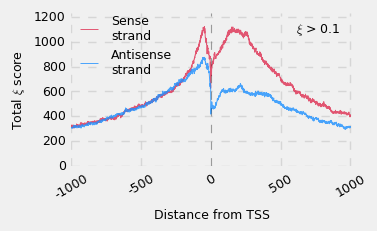

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
max_y = 0

a = gene_array_exp['sense']
idx = np.where((a.max(axis=1) > 0.1))[0]
exp = a[idx, :].sum(axis=0)
ax.plot(exp, c='crimson', lw=0.7, alpha=0.7, label='Sense\nstrand')
max_y = max(max_y, exp.max())

a = gene_array_exp['antisense']
idx = np.where((a.max(axis=1) > 0.1))[0]
exp = a[idx, :].sum(axis=0)
ax.plot(exp, c='dodgerblue', lw=0.7, alpha=0.8, label='Antisense\nstrand')
max_y = max(max_y, exp.max())

ax.axvline(1000, lw=0.5, ls='--', c='k', alpha=0.4)
ax.legend(frameon=False, fontsize=9, loc=(0, 0.55))
ax.set_ylabel(r'Total $\xi$ score', fontsize=9)
ax.set_xlabel('Distance from TSS', fontsize=9)
ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=30)
ax.set_xlim((0, 2010))
ax.text(0.8, 0.87, r'$\xi$ > 0.1', fontsize=9, transform=ax.transAxes)
ax.set_ylim((0, max_y + 0.1 * max_y))
clean_axis(ax)

plt.tight_layout()
plt.savefig('promoter_high_exp_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('promoter_high_exp_scores.svg', transparent=True, edgecolor='none')
plt.show()

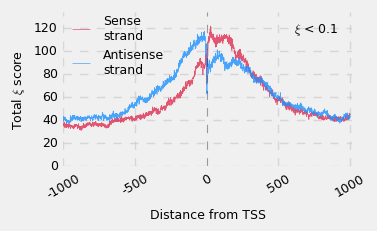

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
max_y = 0

a = gene_array_exp['sense']
idx = np.where((a.max(axis=1) < 0.1))[0]
exp = a[idx, :].sum(axis=0)
ax.plot(exp, c='crimson', lw=0.5, alpha=0.7, label='Sense\nstrand')
max_y = max(max_y, exp.max())

a = gene_array_exp['antisense']
idx = np.where((a.max(axis=1) < 0.1))[0]
exp = a[idx, :].sum(axis=0)
ax.plot(exp, c='dodgerblue', lw=0.5, alpha=0.8, label='Antisense\nstrand')
max_y = max(max_y, exp.max())

ax.axvline(1000, lw=0.5, ls='--', c='k', alpha=0.4)
ax.legend(frameon=False, fontsize=9, loc=(0, 0.55))
ax.set_ylabel(r'Total $\xi$ score', fontsize=9)
ax.set_xlabel('Distance from TSS', fontsize=9)
ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=30)
ax.set_xlim((0, 2010))
ax.text(0.8, 0.87, r'$\xi$ < 0.1', fontsize=9, transform=ax.transAxes)
ax.set_ylim((0, max_y + 0.1 * max_y))
clean_axis(ax)

plt.tight_layout()
plt.savefig('promoter_low_exp_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('promoter_low_exp_scores.svg', transparent=True, edgecolor='none')
plt.show()

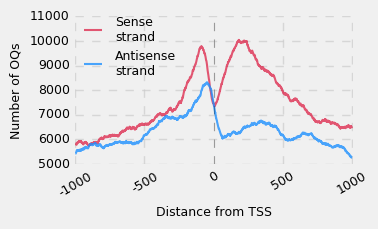

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))


ax.plot(gene_array_oq['sense'].sum(axis=0), c='crimson',
        lw=1.5, alpha=0.7, label='Sense\nstrand')
ax.plot(gene_array_oq['antisense'].sum(axis=0), c='dodgerblue',
        lw=1.5, alpha=0.8, label='Antisense\nstrand')
max_y = max(gene_array_oq['sense'].sum(axis=0).max(),
            gene_array_oq['antisense'].sum(axis=0).max())

ax.axvline(1000, lw=0.5, ls='--', c='k', alpha=0.4)
ax.legend(frameon=False, fontsize=9, loc=(0, 0.55))
ax.set_ylabel('Number of OQs', fontsize=9)
ax.set_xlabel('Distance from TSS', fontsize=9)
ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=30)
ax.set_xlim((0, 2010))
#ax.set_ylim((0, max_y + 0.1 * max_y))
clean_axis(ax)

plt.tight_layout()
plt.savefig('promoter_OQs.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('promoter_OQs.svg', transparent=True, edgecolor='none')
plt.show()


In [19]:
gene_array_g4 = {}
for orient in ['sense', 'antisense']:
    gene_array_g4[orient] = {}
    for loop in [3, 15]:
        for bulge in [0, 3]:
            gene_array_g4[orient]["%d_%d" % (loop, bulge)] = np.load(
                './data/gene_arrays/g3_%s_%s_%s.npy' % (loop, bulge, orient))

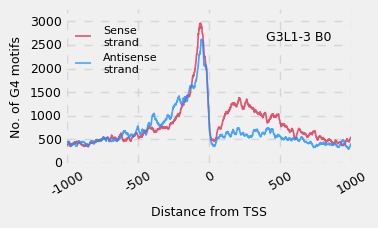

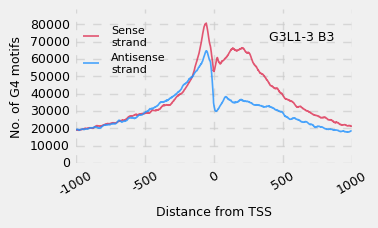

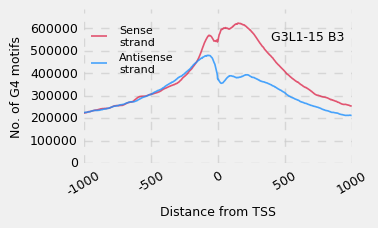

In [65]:
loops_bulges = [[3, 0], [3, 3], [15, 3]]

for lb in loops_bulges:
    max_y = 0
    fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
    
    a = gene_array_g4['sense']["%d_%d" % (lb[0], lb[1])]
    ax.plot((a.sum(axis=0)), lw=1.2, alpha=0.7,
            color='crimson', label='Sense\nstrand')
    max_y = max(max_y, a.sum(axis=0).max())
    
    a = gene_array_g4['antisense']["%d_%d" % (lb[0], lb[1])]
    ax.plot((a.sum(axis=0)), lw=1.2, alpha=0.8,
            color='dodgerblue', label='Antisense\nstrand')
    max_y = max(max_y, a.sum(axis=0).max())
    
    ax.set_ylabel('No. of G4 motifs', fontsize=9)
    ax.set_xlabel('Distance from TSS', fontsize=9)
    ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=30)
    ax.legend(frameon=False, loc=(0, 0.55), fontsize=8, ncol=1)
    ax.text(0.7, 0.8, "G3L1-%d B%d" % (lb[0], lb[1]), fontsize=9, transform=ax.transAxes)
    ax.set_ylim((0, max_y + 0.1 * max_y))
    clean_axis(ax)
    
    plt.tight_layout()
    plt.savefig('promoter_motifs_%d_%d.png' % (lb[0], lb[1]),
                dpi=300, transparent=True, edgecolor='none')
    plt.savefig('promoter_motifs_%d_%d.svg' % (lb[0], lb[1]),
                transparent=True, edgecolor='none')
    plt.show()

In [7]:
gene_phastcons = np.load('./data/gene_arrays/gene_phastcons.npy')

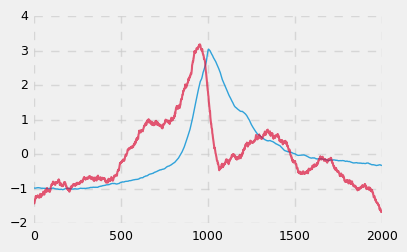

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
ax.plot(zscore(gene_phastcons.mean(axis=0)), lw=1)
ax.plot(zscore(gene_array_oq['antisense'].mean(axis=0)), c='crimson',
        lw=1.5, alpha=0.7, label='Antisense\nstrand')
clean_axis(ax)
plt.show()

200015it [00:20, 9609.58it/s]


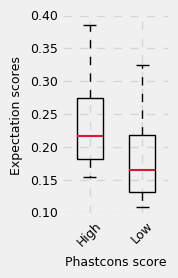

MannwhitneyuResult(statistic=119745579.5, pvalue=0.0)

In [196]:
top_quantile = []
bottom_quantile = []
for i,j in tqdm(zip(gene_phastcons, gene_array_exp['antisense'])):
    top_quantile.append(j[:1000][i[:1000].argsort()[:100]])
    bottom_quantile.append(j[:1000][i[:1000].argsort()[-100:]])
top_quantile = np.array(top_quantile)
bottom_quantile = np.array(bottom_quantile)

a = sorted(top_quantile.max(axis=1))[::-1][:int(top_quantile.shape[0]/10)]
b = sorted(bottom_quantile.max(axis=1))[::-1][:int(bottom_quantile.shape[0]/10)]
len(a), len(b)

fig, ax = plt.subplots(1, 1, figsize=(2, 3))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([a, b], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylabel('Expectation scores', fontsize=9)
ax.set_xticklabels(['High', 'Low'], rotation=45, fontsize=9)
ax.set_xlabel('Phastcons score', fontsize=9)
clean_axis(ax)

plt.tight_layout()
plt.show()

mannwhitneyu(a, b)

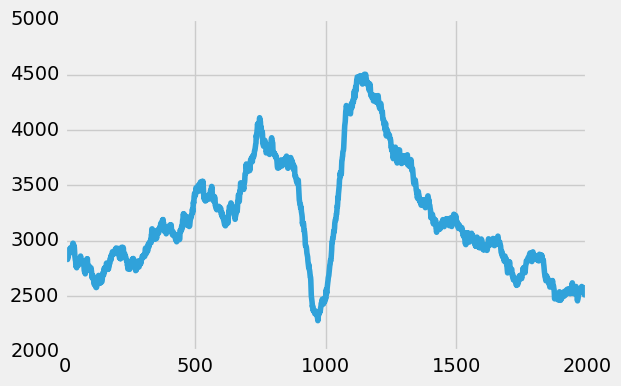

In [231]:
plt.plot(oq_utr.sum(axis=0))
plt.show()

In [235]:
import json

gencode = json.load(
    open('/home/parashar/scratch/hg19_resource/gencode/hg19_gencode.json'))

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']

exonintron_info = {}
for chrom in chroms:
    exonintron_info[chrom] = []

In [234]:
for n, i in enumerate(gencode):
    print (i)
    print (gencode[i])
    print ()
    if n > 10:
        break

ENST00000517742.1_2
{'start_codon': [['97797126', '97797128']], 'chrom': 'chr8', 'gene_name': 'CPQ', 'strand': '+', 'CDS': [['97797126', '97797558'], ['97847201', '97847325']], 'UTR': [['97657603', '97657630'], ['97671512', '97671551'], ['97797092', '97797125']], 'exon': [['97657603', '97657630'], ['97671512', '97671551'], ['97797092', '97797558'], ['97847201', '97847325']]}

ENST00000477161.1_1
{'gene_name': 'FAM171A1', 'strand': '-', 'chrom': 'chr10', 'exon': [['15290638', '15290706'], ['15262943', '15263059'], ['15256170', '15256600']]}

ENST00000439552.1_1
{'gene_name': 'Z95114.7', 'strand': '+', 'chrom': 'chr22', 'exon': [['36571905', '36572574']]}

ENST00000563899.1_1
{'gene_name': 'SPTBN5', 'strand': '-', 'chrom': 'chr15', 'exon': [['42142067', '42142770'], ['42140569', '42140826']]}

ENST00000509751.1_1
{'gene_name': 'HTT', 'strand': '+', 'chrom': 'chr4', 'exon': [['3213639', '3213869'], ['3214291', '3214782']]}

ENST00000483778.5_1
{'gene_name': 'ATG4B', 'strand': '+', 'chrom'

In [ ]:
for n, i in enumerate(gencode):
    if gencode[i]['chrom'] not in chroms:
        continue
    if gencode[i]['strand'] == '+':
        if 'start_codon' in gencode[i]:
            for exon in gencode[i]['exon']:
                if int(exon[0]) > int(gencode[i]['start_codon'][0])
            utr5_info[gencode[i]['chrom']].append('\t'.join([
                gencode[i]['chrom'], gencode[i]['exon'][0][1],
                str(int(gencode[i]['exon'][0][1]) + 1), i, '0', '+'
            ]))
    elif gencode[i]['strand'] == '-':
        if 'start_codon' in gencode[i]:
            utr5_info[gencode[i]['chrom']].append('\t'.join([
                gencode[i]['chrom'], gencode[i]['exon'][0][1],
                str(int(gencode[i]['exon'][0][1]) + 1), i, '0', '-'
            ]))



In [ ]:
for chrom in chroms:
    with open('/home/parashar/scratch/hg19_resource/gencode/chrom_wise_genocode_utr_5/%s.bed' %
              chrom, 'w') as OUT:
        OUT.write('\n'.join(utr5_info[chrom]))